<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Relevant_NN%2BMLE(with_corrections)_seperable_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quadprog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 2.8 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data

from tqdm.auto import tqdm
import random as rng
import quadprog

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import unitary_group
from scipy.stats import norm

In [3]:
def quadprog_solve_qp(v,nQubit):
    """
    Projects unphysical probability vectors onto the nearest physical solution, which lie on a 2^n dimensional simplex.
    Therefore solves a quadratic equation as described in https://scaron.info/blog/quadratic-programming-in-python.html
    1/2 x^T P x + q^T x is the quadratic function to be minimized. (||x-v||^2 = (Mx-v)^T (Mx-v) = 1/2 x^T (M^T M) x + (-M^T b)^T x = 1/2 x^T P x + q^T x)
    G x <= h defines the constraint that x has to be positive.
    A x = b defines the constraint that the probabilities of a vector have to sum to one.
    """

    M = np.eye(2**nQubit)
    P = np.dot(M.T, M)
    q = -np.dot(M.T, v)
    G = -np.eye(2**nQubit)
    h = np.zeros(2**nQubit)
    A = np.concatenate((np.ones(2**nQubit),np.zeros(4**nQubit-2**nQubit))).reshape((2**nQubit,2**nQubit))
    b = np.concatenate((np.ones(1),np.zeros(2**nQubit-1)))

    # For this solver inequalities and equalities are being combined

    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    qp_C = -np.vstack([A, G]).T
    qp_b = -np.hstack([b, h])
    meq = A.shape[0]

    # Minimize the function under the given constraints

    arr = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

    return np.where(np.abs(arr) < 10**-14, 0, arr) # sets all values below 10**-14 to zero, to prevent negative values in the order of computational accuracy

In [4]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [5]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [6]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [7]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [8]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [9]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    Since the probabilities are real numbers, the imaginary part gets discarded.
    """
    probabilities = np.einsum('lii->l',np.einsum('ij,ljk->lik',state,POVM,optimize=True))
    return np.real(probabilities)

In [10]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [11]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [12]:
def MLE(nQubits,calibration_states,noisy_probabilities,POVM_ideal,p,samplesize):
    """
    Reconstructs POVM as described in https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.024102
    calibration_states: axis 0 = state, axis 1 = row, axis 2 = column
    noisy_probabilities: axis 0 = state, axis 1 = probabilities
    POVM_ideal / _reconstructed: axis 0 = element, axis 1 = row, axis 2 = column
    numb_of_detections: axis 0 = POVM_element, axis 1 = states, values = counts
    p_ideal: axis 0 = POVM_element, axis 1 = states, values = current ideal probability
    fracs: axis 0 = POVM_element, axis 1 = states, values = fractions
    """

    numb_of_detections = noisy_probabilities.T * samplesize # absolute occurences -> in this case probability times samplesize

    # boundaries when the loop should be interupted
    loop_num = 0
    loop_max = 2*10**3
    dist = 1
    dist_min = 10**-9

    # first guess for the reconstructed POVM is the noise channel applied to the ideal POVM (without noise)
    POVM_reconstructed = np.array([p/2**nQubits*np.eye(2**nQubits) + (1-p)*POVM_elem for POVM_elem in POVM_ideal])

    while loop_num < loop_max and dist > dist_min:

        p_ideal = np.array([perform_multi_qubit_measurement(state,POVM_reconstructed) for state in calibration_states]).T
        fracs = numb_of_detections/p_ideal

        G = np.einsum('lm,ln,nij,ljk,mko->io',fracs,fracs,calibration_states,POVM_reconstructed,calibration_states,optimize=True)

        eig_vals,U = sp.linalg.eig(G)
        l_sqrt_inv = np.diag(1/np.sqrt(eig_vals))
        l_inv = U@l_sqrt_inv@U.conj().T # -> why not as in paper: U_dagger L_sqrt U ???

        R = np.einsum('ij,lm,mjk->lik',l_inv,fracs,calibration_states,optimize=True)

        POVM_reconstruction_old = POVM_reconstructed
        POVM_reconstructed = np.einsum('lij,ljk,lmk->lim',R,POVM_reconstructed,R.conj(),optimize=True)

        # as a measure of improvement the 2-norm is computed for the difference between the old and new POVM elements and then the differences are added
        dist = np.sum([np.linalg.norm(POVM_reconstructed-POVM_reconstruction_old)])

        if loop_num % 50 == 0:
            print(f'loop number: {loop_num}, distance: {dist}')

        loop_num += 1

    print(f'final loop number: {loop_num}, final distance: {dist}')

    return POVM_reconstructed, dist

In [13]:
def loss_fn(state, params, batch_input, batch_target_output):
    """
    This loss function first calculates the NN output (predictions) for the given batch with the current weights and biases.
    Then it calculates the loss. Therefore it calculates the cross entropy (-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1) )
    (because they use this in the original paper https://iopscience.iop.org/article/10.1088/1367-2630/ac7b3d/pdf)
    To get the loss for the whole batch the mean is taken.
    """
    predictions = state.apply_fn(params, batch_input)
    #loss = jnp.mean(optax.softmax_cross_entropy(predictions,batch_target_output)) -> Somehow doesn't work, has to be calculated manualy
    loss = jnp.mean(-jnp.sum(batch_target_output*jax.lax.log(predictions),axis=1))
    return loss

In [14]:
@jax.jit
def accuracy_MSE(acc_input, acc_target_output,nQubit):
  """
  Calculates the mean mean squared error for the given batch
  """
  acc = jnp.mean(jnp.sum(jnp.abs(acc_input-acc_target_output)**2,axis=-1)/(2**nQubit))
  return acc

In [15]:
@jax.jit
def accuracy_KLD(acc_input, acc_target_output):
  """
  Calculates the mean Kullback-Leibler divergence for the given batch
  """
  acc = jnp.mean(jnp.sum(acc_target_output*jnp.log(acc_target_output/acc_input),axis=-1))
  return acc

In [16]:
@jax.jit
def accuracy_IF(acc_input, acc_target_output):
  """
  Calculates the mean infidelity (not quantum) for the given batch
  """
  acc = jnp.mean(1-(jnp.sum(jnp.sqrt(acc_target_output*acc_input),axis=-1))**2)
  return acc

In [17]:
def linear_inversion(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize,desired_probabilities,test_probs,desired_test_probs):
    """
    Calculates the corrected probabilities by applying a linear inversion matrix L_inv.
    Assuming that the off-diagnoal elements of the elements of the reconstructed POVM are close to zero,
    L is gained by using the diagonal elements of the POVM elements as the columns of L.
    Then L can be converted and multiplied with the probability vectors.
    The inversion can lead to unphysical solutions (negative probabilities).
    These are being projected to the nearest physical solution.

    calibration_states are the states used for training of the NN, thus the index _tr for some variables / data
    """

    POVM_recon, dist = MLE(nQubit,calibration_states,calibration_probabilities,POVM,p,samplesize)

    L = np.zeros((2**nQubit,2**nQubit))

    for i in range(2**nQubit):
        for j in range(2**nQubit):
            L[j][i] = POVM_recon[i][j][j] # The j'th diagonal element of the i'th POVM element is used as the i'th element of the j'th row of L

    L_inv = np.linalg.inv(L) # invert L

    probs_cor = np.einsum('ij,lj->li',L_inv,test_probs,optimize=True)
    probs_cor_tr = np.einsum('ij,lj->li',L_inv,calibration_probabilities,optimize=True)

    # Determining and correcting the unphysical solutions
    mask = np.any(probs_cor< 0, axis=-1)
    mask_tr = np.any(probs_cor_tr < 0, axis=-1)

    for i, element in enumerate(probs_cor):
        if mask[i] == True:
            physical = quadprog_solve_qp(v=element,nQubit=nQubit)
            for j in range(2**nQubit):
                probs_cor[i][j] = physical[j]

    for i, element in enumerate(probs_cor_tr):
        if mask_tr[i] == True:
            physical = quadprog_solve_qp(v=element,nQubit=nQubit)
            for j in range(2**nQubit):
                probs_cor_tr[i][j] = physical[j]

    # Checking whether some unphysical solutions remain
    mask2 = np.any(probs_cor< 0, axis=-1)
    mask_tr2 = np.any(probs_cor_tr < 0, axis=-1)

    # Counting the number of unphysical solutions before and after the corrections
    negs = np.sum(mask)
    negs_tr = np.sum(mask_tr)
    negs2 = np.sum(mask2)
    negs_tr2 = np.sum(mask_tr2)

    # Calculating the different accuracies
    acc_MSE = accuracy_MSE(probs_cor, desired_test_probs,nQubit)
    acc_MSE_tr = accuracy_MSE(probs_cor_tr, desired_probabilities,nQubit)

    acc_KLD = accuracy_KLD(probs_cor, desired_test_probs)
    acc_KLD_tr = accuracy_KLD(probs_cor_tr, desired_probabilities)

    acc_IF = accuracy_IF(probs_cor, desired_test_probs)
    acc_IF_tr = accuracy_IF(probs_cor_tr, desired_probabilities)

    return POVM_recon, probs_cor, [acc_MSE,acc_MSE_tr], [acc_KLD,acc_KLD_tr], [acc_IF,acc_IF_tr], [negs, negs_tr, negs2, negs_tr2]

In [18]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output):
    """
    Performs one training step of the network and returns the updated weights and biases (contained in state)
    """
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [19]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output,nQubit, num_epochs = 100):
  """
  Trains the network for num_epochs epochs.
  Also calculates the different accuracies after each training step.
  """

  # Lists to be filled with the different accuracies for the test, training and unmitigated test data
  acc_test_MSE = []
  acc_training_MSE = []
  acc_unmitigated_test_MSE = []

  acc_test_KLD = []
  acc_training_KLD = []
  acc_unmitigated_test_KLD = []

  acc_test_IF = []
  acc_training_IF = []
  acc_unmitigated_test_IF = []

  # for each epoch updates the paramters for each batch of the training data
  for epoch in tqdm(range(num_epochs)):
    for i in range(len(batched_training_input)):
      state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i])

    # after each paramter update calculates the NN output to compute the accuracies
    predictions_test = state.apply_fn(state.params, acc_input)
    predictions_training = state.apply_fn(state.params, batched_training_input)

    acc_test_MSE.append(accuracy_MSE(predictions_test, acc_target_output,nQubit))
    acc_training_MSE.append(accuracy_MSE(predictions_training, batched_training_target_outputs,nQubit))
    acc_unmitigated_test_MSE.append(accuracy_MSE(acc_input, acc_target_output,nQubit))

    acc_test_KLD.append(accuracy_KLD(predictions_test, acc_target_output))
    acc_training_KLD.append(accuracy_KLD(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_KLD.append(accuracy_KLD(acc_input, acc_target_output))

    acc_test_IF.append(accuracy_IF(predictions_test, acc_target_output))
    acc_training_IF.append(accuracy_IF(predictions_training, batched_training_target_outputs))
    acc_unmitigated_test_IF.append(accuracy_IF(acc_input, acc_target_output))

  return state, [acc_test_MSE, acc_training_MSE, acc_unmitigated_test_MSE], [acc_test_KLD, acc_training_KLD, acc_unmitigated_test_KLD], [acc_test_IF, acc_training_IF, acc_unmitigated_test_IF]

In [20]:
def numpy_collate(batch):
    """
    Needed for making batches later on.
    """
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [21]:
class MLP(nn.Module):
  """
  Defining features of the network (e.g. activation function)
  """
  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)

  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation)
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation) # using a relu activation function for all but the last layer
    return jax.nn.softmax(activation) # appliying a softmax function in the last layer

In [22]:
# Set all variables that need to be preselected
nQubit_list = [2,3,4,5]
training_states_list = [1800,3800,7800,9900]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

# Lists for storing the accuracies (to plot them later on)
MSE_data_LI_list = []
KLD_data_LI_list = []
IF_data_LI_list = []
MSE_data_NN_list = []
KLD_data_NN_list = []
IF_data_NN_list = []


for i in range(0,4):
    nQubit = nQubit_list[i]
    layers_list = [[20,20,20,20,20,2**nQubit],[40,40,2**nQubit],[80,80,80,80,80,80,80,2**nQubit],[160,160,160,160,160,2**nQubit]]     # number of neurons per layer for each qubit number
    layers = layers_list[i]
    training_states = training_states_list[i]

    training_data = np.zeros((training_states,2**nQubit*2))
    test_data = np.zeros((test_states,2**nQubit*2))
    POVM = generate_POVM(theta,phi,nQubit)                # POVM elements are projectors onto the multi qubit z-basis

    model = MLP(num_neurons_per_layer=layers)             # Initialize network
    x_key, init_key = random.split(random.PRNGKey(0))
    x = random.normal(x_key, (batch_size, 2**nQubit))     # Batch size 100, input size 2
    params = model.init(init_key, x)                      # Initialize network params (biases being initialized as zeros)
    optimizer = optax.adam(learning_rate=learning_rate)   # selecting an optimizer with a certain learning rate
    # Not exactly sure how train_state modul works
    # a train state contains the current parameters (weights, biases) and the optimizer
    model_state = train_state.TrainState.create(apply_fn=model.apply,params=params,tx=optimizer)

    # Lists for storing generated data
    calibration_states_list = []                          # only needed for MLE, contains states that are used for POVM reconstruction, also used to determine probabilities for NN training
    calibration_probs_list = []                           # probabilities for NN training
    desired_probs_list = []                               # desired output for NN training input
    test_probs_list = []                                  # test input probabilities
    desired_test_probs_list = []                          # desired test output probabilities

    # Generating training data
    for i in tqdm(range(training_states)):
        state = generate_random_seperable_pure_state(nQubit)                # generating a random seperable pure state
        calibration_states_list.append(state)                               # storing this state for MLE
        probs = perform_multi_qubit_measurement(state,POVM)                 # calculating the probabilites without any noise
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)   # calculating the probabilities after having applyied a depolarizing noise channel
        noisy_probs_sampled = sampling(noisy_probs,samplesize)              # sampling from this noisy probability distribution
        calibration_probs_list.append(noisy_probs_sampled)
        desired_probs_list.append(probs)
        for j in range(2**nQubit):
            training_data[i][j] = noisy_probs_sampled[j]
            #training_data[i][j] = noisy_probs[j]                           # -> used if no sampling is needed / wanted
            training_data[i][j+2**nQubit] = probs[j]

    # Generating test data
    for i in tqdm(range(test_states)):
        state = generate_random_seperable_pure_state(nQubit)
        probs = perform_multi_qubit_measurement(state,POVM)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        noisy_probs_sampled = sampling(noisy_probs,samplesize)
        test_probs_list.append(noisy_probs_sampled)
        desired_test_probs_list.append(probs)
        for j in range(2**nQubit):
            test_data[i][j] = noisy_probs_sampled[j]
            #test_data[i][j] = noisy_probs[j]                               # -> used if no sampling is needed / wanted
            test_data[i][j+2**nQubit] = probs[j]

    # Batching the training data
    data_loader_training = data.DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_training_input = []
    batched_training_target_outputs = []

    # Splitting the noisy data from the true data
    for batch in data_loader_training:
      inputs, targets = jnp.split(batch,2,axis=1)
      batched_training_input.append(inputs)
      batched_training_target_outputs.append(targets)

    # Batching the test data
    data_loader_test = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
    batched_test_input = []
    batched_test_target_outputs = []

    # Splitting the noisy data from the true data
    for batch in data_loader_test:
      inputs, targets = jnp.split(batch,2,axis=1)
      batched_test_input.append(inputs)
      batched_test_target_outputs.append(targets)

    # Converting the NN data to jax numpy arrays
    batched_tr_inp = jnp.asarray(batched_training_input)
    batched_tr_tar_out = jnp.asarray(batched_training_target_outputs)
    batched_test_inp = jnp.asarray(batched_test_input)
    batched_test_tar_out = jnp.asarray(batched_test_target_outputs)

    # Converting the MLE data to numpy arrays
    calibration_states = np.asarray(calibration_states_list)
    calibration_probs = np.asarray(calibration_probs_list)
    desired_probs = np.asarray(desired_probs_list)
    test_probs = np.asarray(test_probs_list)
    desired_test = np.asarray(desired_test_probs_list)

    # Performing the linear inversion and saving accuracy data
    POVM_reconstructed, probs_corrected, MSE_data_LI, KLD_data_LI, IF_data_LI, neg_probs = linear_inversion(nQubit,calibration_states,calibration_probs,POVM,p,samplesize,desired_probs,test_probs,desired_test)
    MSE_data_LI_list.append(MSE_data_LI)
    KLD_data_LI_list.append(KLD_data_LI)
    IF_data_LI_list.append(IF_data_LI)

    # Performing the NN and saving accuracy data
    trained_model_state, MSE_data, KLD_data, IF_data = train_model(model_state, batched_tr_inp, batched_tr_tar_out,
                                                                  batched_test_inp, batched_test_tar_out,
                                                                  nQubit=nQubit, num_epochs = num_epochs)
    MSE_data_NN_list.append(MSE_data)
    KLD_data_NN_list.append(KLD_data)
    IF_data_NN_list.append(IF_data)


    # Print out how many unphysical solutions we got through the linear inversion before and after correcting for them
    print(neg_probs[0], 'out of', test_states, 'test states lead to negative probablities after the linear inversion (check: ',neg_probs[2], ')')
    print(neg_probs[1], 'out of', training_states, 'training states lead to negative probablities after the linear inversion (check: ',neg_probs[3], ')')

  0%|          | 0/1800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loop number: 0, distance: 0.0011305225778660522
loop number: 50, distance: 6.250372521761407e-06
loop number: 100, distance: 5.242465714020671e-07
loop number: 150, distance: 4.451543340355874e-08
loop number: 200, distance: 3.797870056612577e-09
final loop number: 229, final distance: 9.589260096942502e-10


<ipython-input-17-efaa6023e0ca>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  L[j][i] = POVM_recon[i][j][j] # The j'th diagonal element of the i'th POVM element is used as the i'th element of the j'th row of L


  0%|          | 0/300 [00:00<?, ?it/s]

3 out of 200 test states lead to negative probablities after the linear inversion (check:  0 )
47 out of 1800 training states lead to negative probablities after the linear inversion (check:  0 )


  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loop number: 0, distance: 0.002816627671408622
loop number: 50, distance: 5.928201276150952e-05
loop number: 100, distance: 2.1352832311242874e-05
loop number: 150, distance: 8.474724936471137e-06
loop number: 200, distance: 3.4534848147989187e-06
loop number: 250, distance: 1.4265684214314624e-06
loop number: 300, distance: 5.948262931758933e-07
loop number: 350, distance: 2.498361096075944e-07
loop number: 400, distance: 1.0557390763813703e-07
loop number: 450, distance: 4.4847632847942675e-08
loop number: 500, distance: 1.9140249774525525e-08
loop number: 550, distance: 8.203236515130675e-09
loop number: 600, distance: 3.5293750538171876e-09
loop number: 650, distance: 1.523908570884095e-09
final loop number: 677, final distance: 9.859873283956329e-10


  0%|          | 0/300 [00:00<?, ?it/s]

24 out of 200 test states lead to negative probablities after the linear inversion (check:  0 )
454 out of 3800 training states lead to negative probablities after the linear inversion (check:  0 )


  0%|          | 0/7800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loop number: 0, distance: 0.005579652269681078
loop number: 50, distance: 0.00016695624208052986
loop number: 100, distance: 8.694606840953234e-05
loop number: 150, distance: 5.473243280923061e-05
loop number: 200, distance: 3.704967493787e-05
loop number: 250, distance: 2.5964345170915383e-05
loop number: 300, distance: 1.8561813924440474e-05
loop number: 350, distance: 1.3440896548599868e-05
loop number: 400, distance: 9.819712279334947e-06
loop number: 450, distance: 7.221308784921709e-06
loop number: 500, distance: 5.3374775233813055e-06
loop number: 550, distance: 3.96121919454364e-06
loop number: 600, distance: 2.9497943952347435e-06
loop number: 650, distance: 2.2029363535763426e-06
loop number: 700, distance: 1.649259782741106e-06
loop number: 750, distance: 1.237423906923651e-06
loop number: 800, distance: 9.302104620218572e-07
loop number: 850, distance: 7.004661186599185e-07
loop number: 900, distance: 5.282756968643375e-07
loop number: 950, distance: 3.989674280402086e-07
l

  0%|          | 0/300 [00:00<?, ?it/s]

76 out of 200 test states lead to negative probablities after the linear inversion (check:  0 )
2526 out of 7800 training states lead to negative probablities after the linear inversion (check:  0 )


  0%|          | 0/9900 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

loop number: 0, distance: 0.012460889986361863
loop number: 50, distance: 0.0004632897897455921
loop number: 100, distance: 0.00028377626879672545
loop number: 150, distance: 0.00019955092912504163
loop number: 200, distance: 0.00015011840108774874
loop number: 250, distance: 0.00011811855258704858
loop number: 300, distance: 9.588575718976452e-05
loop number: 350, distance: 7.958257771667585e-05
loop number: 400, distance: 6.713668685673402e-05
loop number: 450, distance: 5.734810080003637e-05
loop number: 500, distance: 4.947547398787311e-05
loop number: 550, distance: 4.303409189281642e-05
loop number: 600, distance: 3.769166026130574e-05
loop number: 650, distance: 3.321142488639526e-05
loop number: 700, distance: 2.9419384219796154e-05
loop number: 750, distance: 2.618441480482542e-05
loop number: 800, distance: 2.340567196787826e-05
loop number: 850, distance: 2.1004285071115084e-05
loop number: 900, distance: 1.8917697269411214e-05
loop number: 950, distance: 1.709569622605126e-

  0%|          | 0/300 [00:00<?, ?it/s]

130 out of 200 test states lead to negative probablities after the linear inversion (check:  0 )
6244 out of 9900 training states lead to negative probablities after the linear inversion (check:  0 )


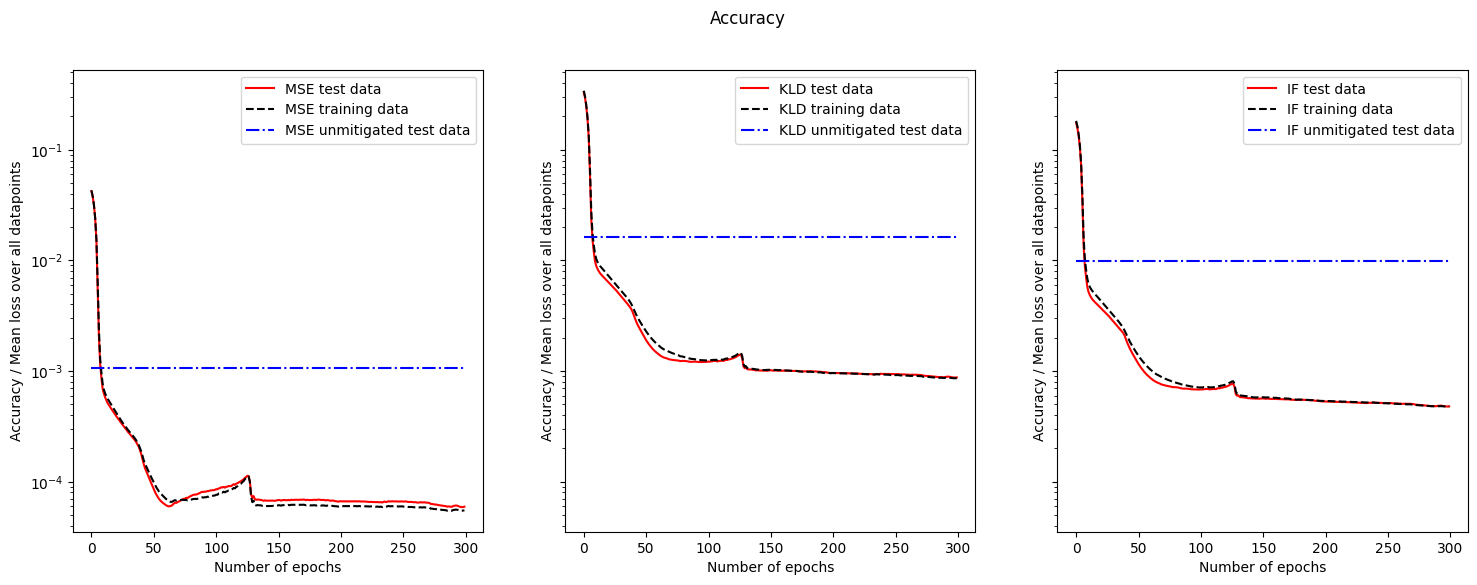

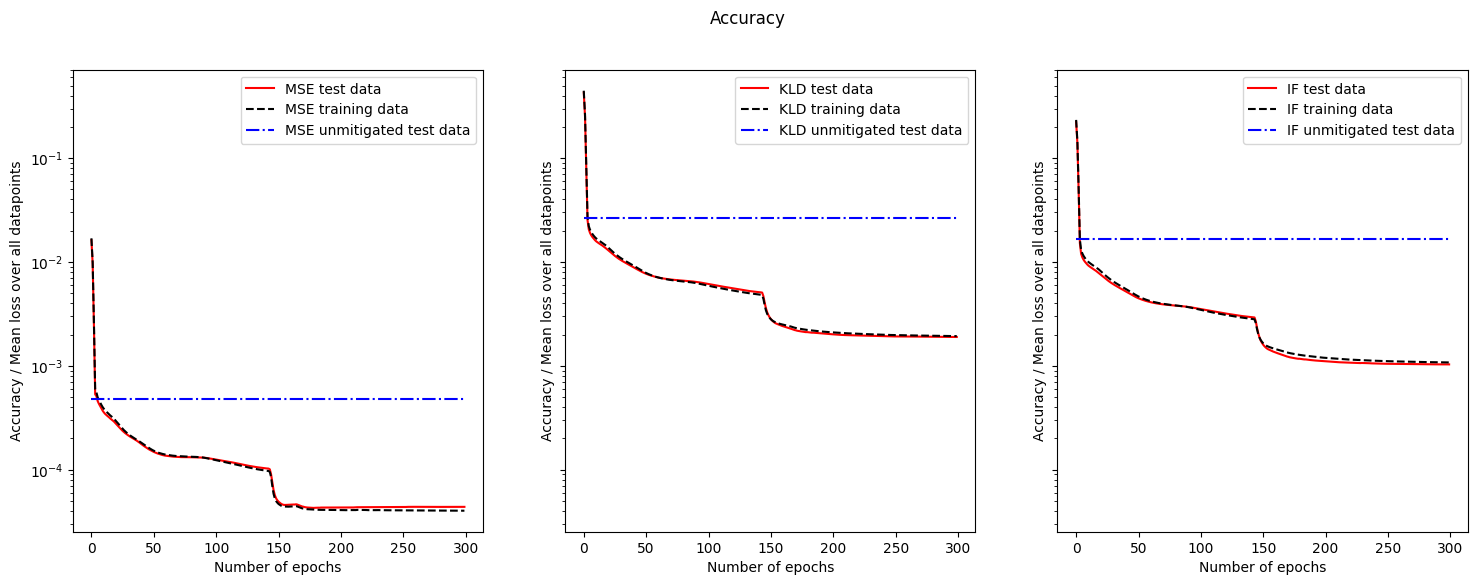

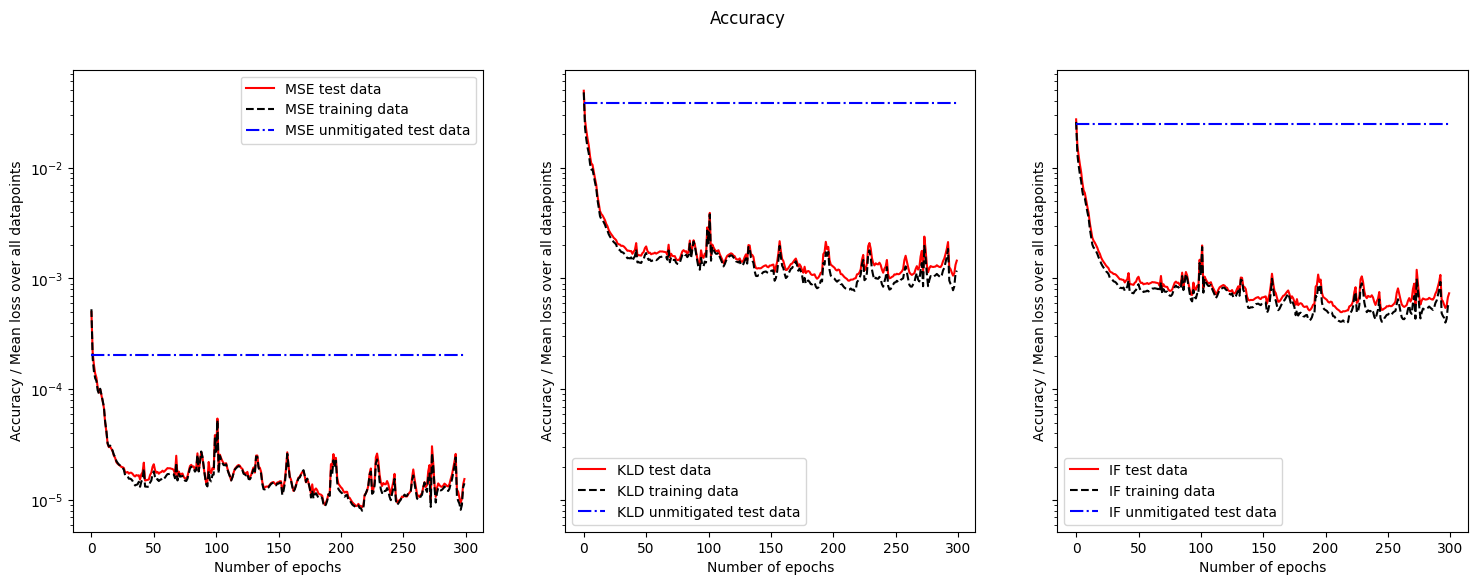

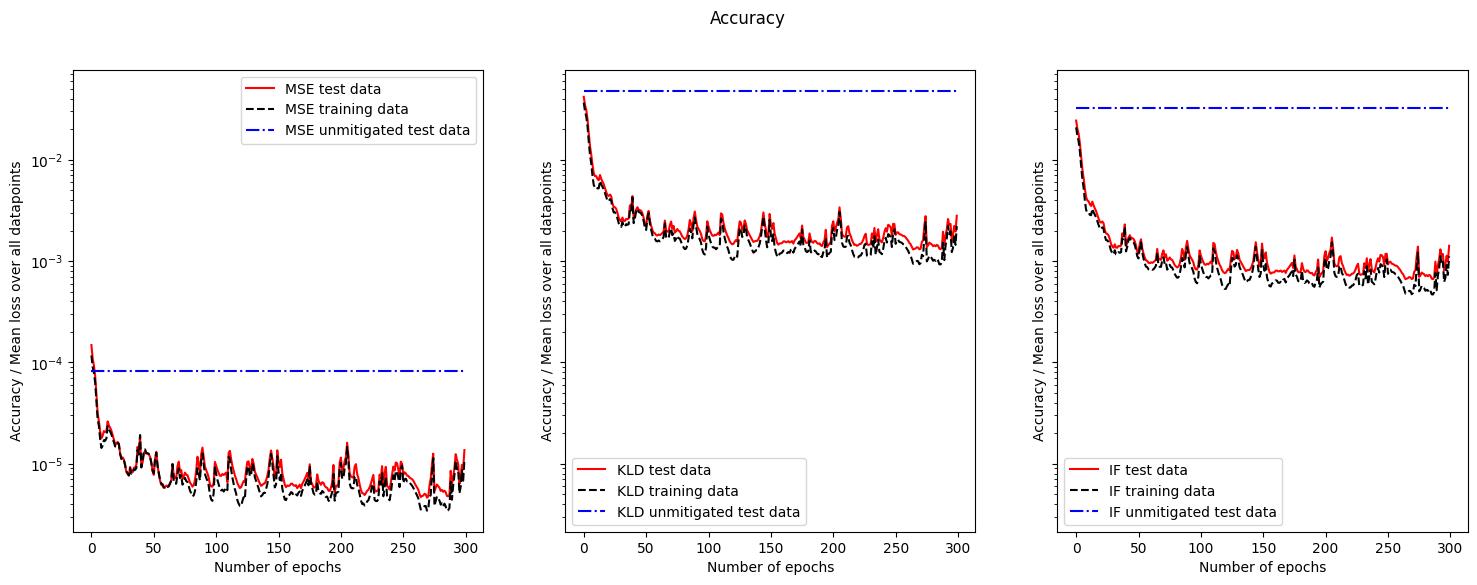

In [23]:
# Plotting the NN accuracies over the number of epochs
i = np.arange(0,num_epochs)

for j in range(0,4):
  fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
  axs[0].plot(i,MSE_data_NN_list[j][0],label="MSE test data",color="red")
  axs[0].plot(i,MSE_data_NN_list[j][1],label="MSE training data",linestyle="--",color="black")
  axs[0].plot(i,MSE_data_NN_list[j][2],label="MSE unmitigated test data",linestyle="-.",color="blue")
  axs[0].set_xlabel('Number of epochs')
  axs[0].set_ylabel('Accuracy / Mean loss over all datapoints')
  axs[0].set_yscale('log')
  axs[0].legend()
  axs[1].plot(i,KLD_data_NN_list[j][0],label="KLD test data",color="red")
  axs[1].plot(i,KLD_data_NN_list[j][1],label="KLD training data",linestyle="--",color="black")
  axs[1].plot(i,KLD_data_NN_list[j][2],label="KLD unmitigated test data",linestyle="-.",color="blue")
  axs[1].set_xlabel('Number of epochs')
  axs[1].set_ylabel('Accuracy / Mean loss over all datapoints')
  axs[1].set_yscale('log')
  axs[1].legend()
  axs[2].plot(i,IF_data_NN_list[j][0],label="IF test data",color="red")
  axs[2].plot(i,IF_data_NN_list[j][1],label="IF training data",linestyle="--",color="black")
  axs[2].plot(i,IF_data_NN_list[j][2],label="IF unmitigated test data",linestyle="-.",color="blue")
  axs[2].set_xlabel('Number of epochs')
  axs[2].set_ylabel('Accuracy / Mean loss over all datapoints')
  axs[2].set_yscale('log')
  axs[2].legend()
  fig.suptitle('Accuracy')

Text(0.5, 0.98, 'NN vs LI improvement')

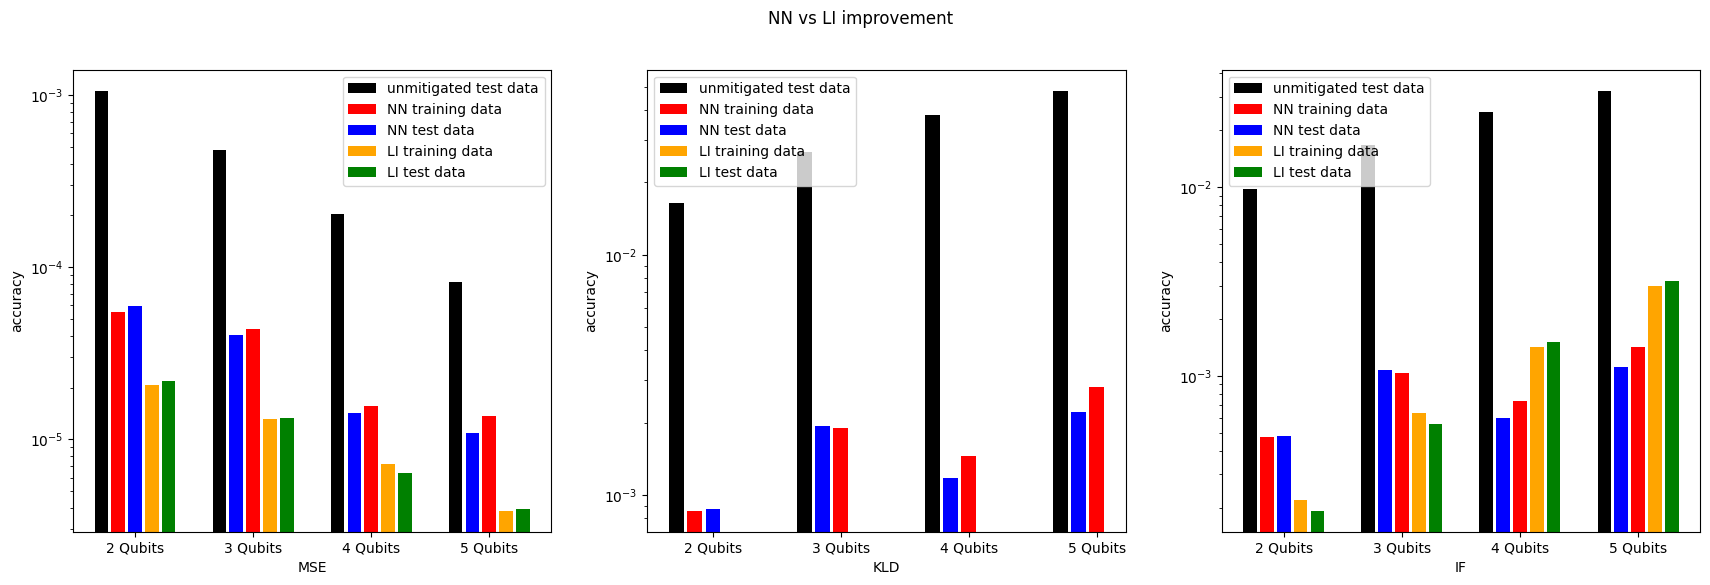

In [24]:
# Plotting the comparison between NN and LI accuracy
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
fig, axs = plt.subplots(1, 3, figsize=(21, 6), sharey=False)

axs[0].bar(0,MSE_data_NN_list[0][2][-1],label="unmitigated test data",color="black")
axs[0].bar(1,MSE_data_NN_list[0][1][-1],label="NN training data",color="red")
axs[0].bar(2,MSE_data_NN_list[0][0][-1],label="NN test data",color="blue")
axs[0].bar(3,MSE_data_LI_list[0][1],label="LI training data",color="orange")
axs[0].bar(4,MSE_data_LI_list[0][0],label="LI test data",color="green")
axs[0].bar(7,MSE_data_NN_list[1][2][-1],color="black")
axs[0].bar(8,MSE_data_NN_list[1][1][-1],color="blue")
axs[0].bar(9,MSE_data_NN_list[1][0][-1],color="red")
axs[0].bar(10,MSE_data_LI_list[1][1],color="orange")
axs[0].bar(11,MSE_data_LI_list[1][0],color="green")
axs[0].bar(14,MSE_data_NN_list[2][2][-1],color="black")
axs[0].bar(15,MSE_data_NN_list[2][1][-1],color="blue")
axs[0].bar(16,MSE_data_NN_list[2][0][-1],color="red")
axs[0].bar(17,MSE_data_LI_list[2][1],color="orange")
axs[0].bar(18,MSE_data_LI_list[2][0],color="green")
axs[0].bar(21,MSE_data_NN_list[3][2][-1],color="black")
axs[0].bar(22,MSE_data_NN_list[3][1][-1],color="blue")
axs[0].bar(23,MSE_data_NN_list[3][0][-1],color="red")
axs[0].bar(24,MSE_data_LI_list[3][1],color="orange")
axs[0].bar(25,MSE_data_LI_list[3][0],color="green")
axs[0].set_xticks([2,9,16,23])
axs[0].set_xticklabels(labels)
axs[0].set_yscale('log')
axs[0].set_xlabel("MSE")
axs[0].set_ylabel("accuracy")
axs[0].legend()

axs[1].bar(0,KLD_data_NN_list[0][2][-1],label="unmitigated test data",color="black")
axs[1].bar(1,KLD_data_NN_list[0][1][-1],label="NN training data",color="red")
axs[1].bar(2,KLD_data_NN_list[0][0][-1],label="NN test data",color="blue")
axs[1].bar(3,KLD_data_LI_list[0][1],label="LI training data",color="orange")
axs[1].bar(4,KLD_data_LI_list[0][0],label="LI test data",color="green")
axs[1].bar(7,KLD_data_NN_list[1][2][-1],color="black")
axs[1].bar(8,KLD_data_NN_list[1][1][-1],color="blue")
axs[1].bar(9,KLD_data_NN_list[1][0][-1],color="red")
axs[1].bar(10,KLD_data_LI_list[1][1],color="orange")
axs[1].bar(11,KLD_data_LI_list[1][0],color="green")
axs[1].bar(14,KLD_data_NN_list[2][2][-1],color="black")
axs[1].bar(15,KLD_data_NN_list[2][1][-1],color="blue")
axs[1].bar(16,KLD_data_NN_list[2][0][-1],color="red")
axs[1].bar(17,KLD_data_LI_list[2][1],color="orange")
axs[1].bar(18,KLD_data_LI_list[2][0],color="green")
axs[1].bar(21,KLD_data_NN_list[3][2][-1],color="black")
axs[1].bar(22,KLD_data_NN_list[3][1][-1],color="blue")
axs[1].bar(23,KLD_data_NN_list[3][0][-1],color="red")
axs[1].bar(24,KLD_data_LI_list[3][1],color="orange")
axs[1].bar(25,KLD_data_LI_list[3][0],color="green")
axs[1].set_xticks([2,9,16,23])
axs[1].set_xticklabels(labels)
axs[1].set_yscale('log')
axs[1].set_xlabel("KLD")
axs[1].set_ylabel("accuracy")
axs[1].legend()

axs[2].bar(0,IF_data_NN_list[0][2][-1],label="unmitigated test data",color="black")
axs[2].bar(1,IF_data_NN_list[0][1][-1],label="NN training data",color="red")
axs[2].bar(2,IF_data_NN_list[0][0][-1],label="NN test data",color="blue")
axs[2].bar(3,IF_data_LI_list[0][1],label="LI training data",color="orange")
axs[2].bar(4,IF_data_LI_list[0][0],label="LI test data",color="green")
axs[2].bar(7,IF_data_NN_list[1][2][-1],color="black")
axs[2].bar(8,IF_data_NN_list[1][1][-1],color="blue")
axs[2].bar(9,IF_data_NN_list[1][0][-1],color="red")
axs[2].bar(10,IF_data_LI_list[1][1],color="orange")
axs[2].bar(11,IF_data_LI_list[1][0],color="green")
axs[2].bar(14,IF_data_NN_list[2][2][-1],color="black")
axs[2].bar(15,IF_data_NN_list[2][1][-1],color="blue")
axs[2].bar(16,IF_data_NN_list[2][0][-1],color="red")
axs[2].bar(17,IF_data_LI_list[2][1],color="orange")
axs[2].bar(18,IF_data_LI_list[2][0],color="green")
axs[2].bar(21,IF_data_NN_list[3][2][-1],color="black")
axs[2].bar(22,IF_data_NN_list[3][1][-1],color="blue")
axs[2].bar(23,IF_data_NN_list[3][0][-1],color="red")
axs[2].bar(24,IF_data_LI_list[3][1],color="orange")
axs[2].bar(25,IF_data_LI_list[3][0],color="green")
axs[2].set_xticks([2,9,16,23])
axs[2].set_xticklabels(labels)
axs[2].set_yscale('log')
axs[2].set_xlabel("IF")
axs[2].set_ylabel("accuracy")
axs[2].legend()

fig.suptitle('NN vs LI improvement')